<a href="https://colab.research.google.com/github/NuelOzeh/Tensorflow-Malaria-Convolutional-Neural-Network/blob/main/Malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, InputLayer, Flatten, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, AUC, Precision, Recall
from tensorflow.keras.callbacks import Callback,EarlyStopping, LearningRateScheduler

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteCC49A5/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
for data in dataset[0].take(3):
    print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(133, 127, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [ ]:
#splitting datasets
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_dataset_temp = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_dataset_temp.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_dataset_temp.skip(int(TEST_RATIO*DATASET_SIZE))

    return train_dataset, val_dataset, test_dataset

In [ ]:
train_dataset, val_dataset, test_dataset = splits(dataset[0],TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

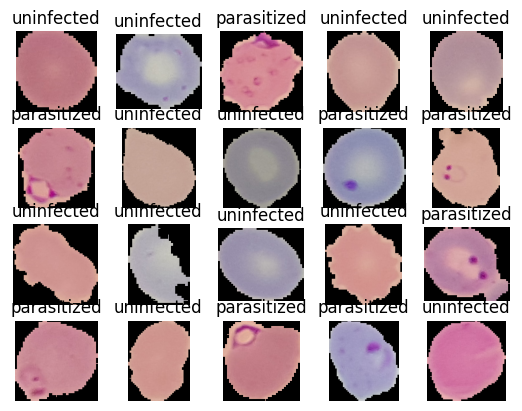

In [ ]:
#visualization
for i, (image, label) in enumerate(train_dataset.take(20)):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

# **DATA PREPROCESSING**



In [ ]:
IMG_SIZE = 224

def resizing_rescaling(image, label):
    return tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0, label

In [ ]:
train_dataset = train_dataset.map(resizing_rescaling)
val_dataset = val_dataset.map(resizing_rescaling)
test_dataset = test_dataset.map(resizing_rescaling)


for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
from keras.layers import BatchNormalization
from warnings import filters
INPUT = 8

lenet_model = tf.keras.Sequential([
                            InputLayer(input_shape = (IMG_SIZE, IMG_SIZE, 3)),
                            Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                            BatchNormalization(),
                            MaxPooling2D(pool_size = 2, strides = 2 ),

                            Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                            BatchNormalization(),
                            MaxPooling2D(pool_size = 2, strides = 2 ),

                            Flatten(),

                            Dense(100, activation = 'relu'),
                            BatchNormalization(),
                            Dense(10, activation = 'relu'),
                            BatchNormalization(),
                            Dense(1, activation = 'sigmoid')
])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

##Early stopping

In [ ]:
es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

###Learning Rate Sheduler

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
LR_sheduler_callback = LearningRateScheduler(scheduler, verbose= 1)

In [ ]:
metrics = [TruePositives(name='tp'), TrueNegatives(name='tn'), FalsePositives(name='fp'), FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'),
           AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]

###Model Training

In [ ]:
lenet_model.compile(loss = BinaryCrossentropy(),
              optimizer = Adam(learning_rate = .01),
              metrics =metrics
)

history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1, callbacks =[es_callback, LR_sheduler_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
689/689 [==============================] - 63s 85ms/step - loss: 0.1507 - tp: 10600.0000 - tn: 10365.0000 - fp: 659.0000 - fn: 422.0000 - accuracy: 0.9510 - auc: 0.9821 - precision: 0.9415 - recall: 0.9617 - val_loss: 0.2238 - val_tp: 1333.0000 - val_tn: 1266.0000 - val_fp: 94.0000 - val_fn: 62.0000 - val_accuracy: 0.9434 - val_auc: 0.9725 - val_precision: 0.9341 - val_recall: 0.9556 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10
689/689 [==============================] - 55s 80ms/step - loss: 0.1290 - tp: 10677.0000 - tn: 10443.0000 - fp: 580.0000 - fn: 346.0000 - accuracy: 0.9580 - auc: 0.9867 - precision: 0.9485 - recall: 0.9686 - val_loss: 0.2260 - val_tp: 1197.0000 - val_tn: 1308.0000 - val_fp: 51.0000 - val_fn: 199.0000 - val_accuracy: 0.9093 - val_auc: 0.9811 - val_precision: 0.9591 - val_recall: 0.8574 - lr: 0.0100

Epoch 3: LearningR

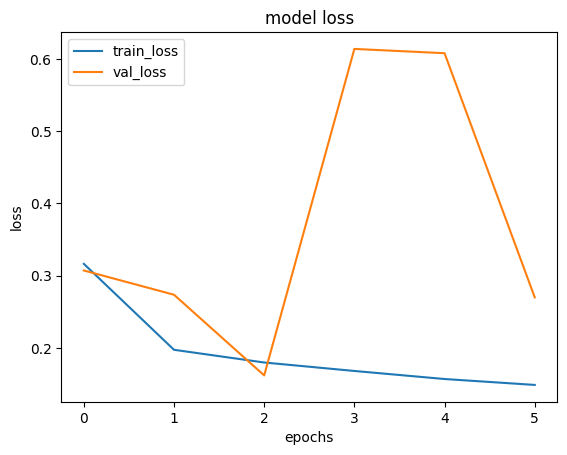

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

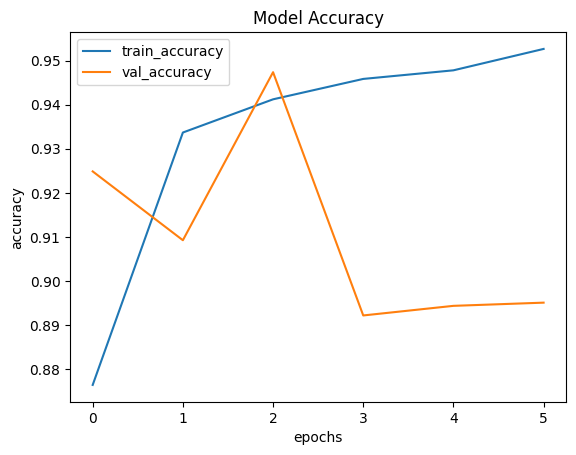

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()